In [189]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [190]:
import numpy as np
import pandas as pd

In [191]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [192]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [193]:
# Create engine using the `hawaii.sqlite` database file
engine=create_engine("sqlite:///Resources/hawaii.sqlite")

In [194]:
# Declare a Base using `automap_base()`
Base=automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [195]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [196]:
# Assign Measurement and Station class to variables
Measurement=Base.classes.measurement
Station=Base.classes.station

In [197]:
# Create a session
session=Session(engine)

In [198]:
# Create the inspector and connect it to the engine
inspector=inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [199]:
# Review measurement table headers and column type
columns=inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [200]:
# Review station table headers and column type
columns=inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

The last date in the database is 2017-08-23
The date one year from the last date in the database is 2016-08-23


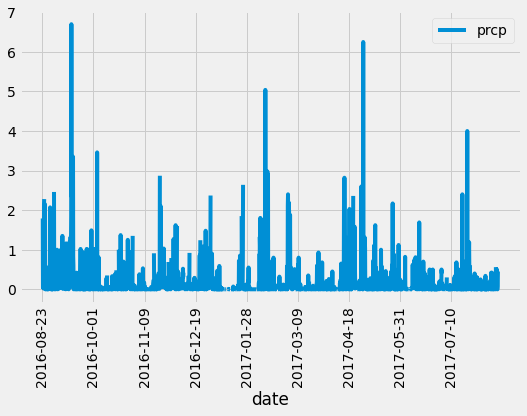

In [201]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()
session.query(func.count(Measurement.date)).all()

# Calculate the date 1 year ago from the last data point in the database
last_data_point=session.query(func.max(Measurement.date)).all()
last_date=dt.date(2017, 8, 23)
print(f"The last date in the database is {last_date}")

one_year_ago=last_date-dt.timedelta(days=365)
print(f"The date one year from the last date in the database is {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
prcp_last_year = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= one_year_ago).\
        filter(Measurement.date <= last_date).all()
prcp_last_year

# # Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_last_year, columns=['date','prcp'])
prcp_df.set_index('date', inplace=True)

# # Sort the dataframe by date
prcp_df = prcp_df.sort_index()

# # Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(use_index=True, y='prcp',
figsize = (8,5))

# Set xticks and rotate dates
xtick_list = np.arange(0,prcp_df.shape[0],250)
ax.set_xticks(xtick_list)
ax.set_xticklabels([prcp_df.index[i] for i in xtick_list], rotation=90)

plt.show()

In [202]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [203]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(func.count(Station.station)).all()
station_count

[(9,)]

In [204]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [205]:
#Find the most active station
most_active_station=most_active_stations[0] 
most_active_station

('USC00519281', 2772)

In [206]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station_calc = session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
most_active_station_calc

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [207]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

active_stations_temps= session.query(Measurement.tobs).\
                        filter(Measurement.date >= "2016-08-23").\
                        filter(Measurement.station == "USC00519281").all()
active_stations_temps
len(active_stations_temps)

all_temps= [x [0] for x in active_stations_temps]

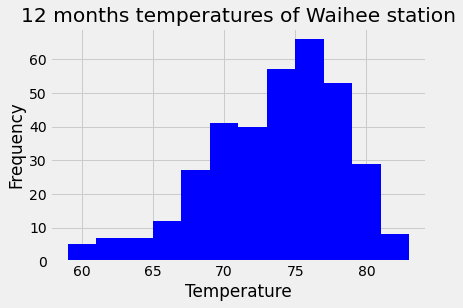

<Figure size 432x288 with 0 Axes>

In [208]:
plt.hist(all_temps, bins=12, color="blue")
plt.title("12 months temperatures of Waihee station")
labels = ['tobs']
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.figure();

## Bonus Challenge Assignment

In [209]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [210]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

In [211]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [212]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [213]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [214]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [215]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [216]:
# Plot the daily normals as an area plot with `stacked=False`
